In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier


## Prototype Model

Generate the prototypes

In [2]:
def gen_prototypes(X_train, y_train):
    ai_proto = np.mean(X_train[y_train == 'ai'], axis=0)
    real_proto = np.mean(X_train[y_train == 'real'], axis=0)
    return ai_proto, real_proto

Categorize each exemplar in the training set by distance to prototype

In [3]:
def prototype_predict(ai_proto, real_proto, stims):
    predictions = []

    for stim in stims:
        dist_ai = -np.linalg.norm(stim - ai_proto)
        dist_real = -np.linalg.norm(stim - real_proto)
        if dist_ai > dist_real:
            predictions.append('ai')
        else:
            predictions.append('real')
    
    return np.array(predictions)

## Exemplar Model

Generate lists of exemplars

In [24]:
def gen_exemplars(X_train, y_train):
    exemplars = {
        'ai': X_train[y_train == 'ai'],
        'real': X_train[y_train == 'real']
    }
    return exemplars

Categorize each exemplar based on highest similarity score to each category

In [ ]:
# def exemplar_predict(stims, exemplars, c=2.0):
#     predictions = []
#     for stim in stims:
#         sim_ai   = np.sum(np.exp(-c * np.linalg.norm(exemplars['ai']   - stimulus, axis=1)))
#         sim_real = np.sum(np.exp(-c * np.linalg.norm(exemplars['real'] - stimulus, axis=1)))

#         if sim_real > sim_ai:
#             predictions.append('real')
#         else:
#             predictions.append('ai')
#     return np.array(predictions)

In [38]:
def exemplar_predict(stims, exemplars, c=2.0):
    predictions = []
    for stim in stims:
        # Calculate distances considering all dimensions 
        distances_ai = np.linalg.norm(exemplars['ai'] - stim.reshape(1, -1), axis=1)
        distances_real = np.linalg.norm(exemplars['real'] - stim.reshape(1, -1), axis=1)
        
        # Calculate similarity scores
        sim_ai = np.sum(np.exp(-c * distances_ai))
        sim_real = np.sum(np.exp(-c * distances_real))
        
        # Make prediction based on highest similarity
        predictions.append('real' if sim_real > sim_ai else 'ai')
            
    return np.array(predictions)

### Results (with ML)

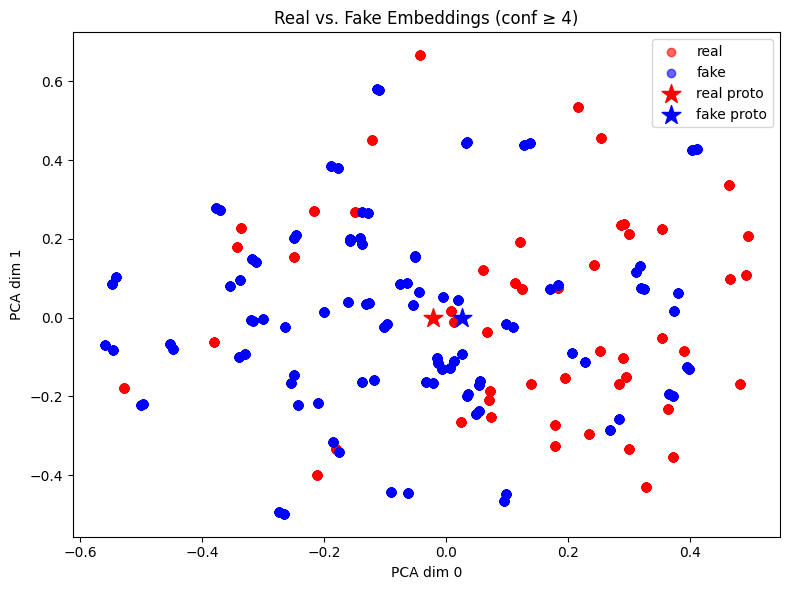

In [36]:
# --- 1) Load & merge ---
df_resp = pd.read_csv("./DATA AND R CODE/eachresponse.csv") \
            .dropna(how="any")

df_pca = pd.read_pickle("df_pca_2")
df_pca["image"] = (
    df_pca["image"]
      .str.extract(r'\((\d+)\)', expand=False)
      .dropna()
      .astype(int)
)

df_merged = pd.merge(df_resp, df_pca, on="image", how="inner")

# --- 2) Filter by confidence ---
confidence = 4   # ← adjust this!
df_merged = df_merged[df_merged["confidence"] >= confidence]

# --- 3) Prepare data for PCA dims 0 & 1 ---
pca_columns = [0, 1]
X = df_merged[pca_columns].values
y = df_merged["choice"].values

# --- 4) Compute prototypes (you already have this) ---
fake_proto, real_proto = gen_prototypes(X, y)

# --- 5) Split out real vs fake for plotting ---
real_pts = df_merged[df_merged["label"] == 1]
fake_pts = df_merged[df_merged["label"] == 0]

# --- 6) Plot ---
plt.figure(figsize=(8,6))

plt.scatter(real_pts[0], real_pts[1],
            color="red",   alpha=0.6, label="real")
plt.scatter(fake_pts[0], fake_pts[1],
            color="blue",  alpha=0.6, label="fake")

# prototypes
plt.scatter(real_proto[0], real_proto[1],
            color="red", marker="*", s=200,
            label="real proto")
plt.scatter(fake_proto[0], fake_proto[1],
            color="blue", marker="*", s=200,
            label="fake proto")

plt.xlabel("PCA dim 0")
plt.ylabel("PCA dim 1")
plt.title(f"Real vs. Fake Embeddings (conf ≥ {confidence})")
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
# [1, 2, 3, 4, 5, 10, 20, 30, 50, 100]
pca_dfs = {
    1:  'df_pca_1',
    2:  'df_pca_2',
    3:  'df_pca_3',
    4:  'df_pca_4',
    5:  'df_pca_5',
    10: 'df_pca_10',
    20: 'df_pca_20',
    30: 'df_pca_30',
    50: 'df_pca_50',
    100:'df_pca_100'
}

results = []

df_resp = pd.read_csv("./DATA AND R CODE/eachresponse.csv")
df_resp = df_resp.dropna(how='any')

for d, df_pca in pca_dfs.items():
    df = pd.read_pickle(df_pca)  
    df["image"] = df["image"].str.extract(r'\((\d+)\)', expand=False)
    df = df.dropna(subset=["image"])  # Drop rows where 'image' is NaN
    df["image"] = df["image"].astype(int)
    
    df_merged = pd.merge(df_resp, df, on="image", how="inner")
    pca_columns = [i for i in range(0, d)]
    
    confidence = 4
    df_merged = df_merged[df_merged["confidence"] >= confidence]
    
    X = df_merged[pca_columns].values
    y = df_merged["choice"].values
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    # Prototype
    ai_proto, real_proto = gen_prototypes(X_train, y_train)
    proto_preds = prototype_predict(ai_proto, real_proto, X_test)
    proto_acc = accuracy_score(y_test, proto_preds)
    
    # Exemplar
    exemplars     = gen_exemplars(X_train, y_train)
    exemplar_preds = exemplar_predict(X_test, exemplars, c=5.0)
    exemplar_acc   = accuracy_score(y_test, exemplar_preds)

    # ML (RidgeClassifier)
    clf = RidgeClassifier()
    clf.fit(X_train, y_train)
    ml_preds = clf.predict(X_test)
    ml_ridge_acc = accuracy_score(y_test, ml_preds)

    # ML (GradientBoostingClassifier)
    clf_gradientBoost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=3)
    clf_gradientBoost.fit(X_train, y_train)
    ml_gradientBoost_preds = clf_gradientBoost.predict(X_test)
    ml_gradientBoost_acc = accuracy_score(y_test, ml_gradientBoost_preds)

    # ML (AdaBoostClassifier)
    clf_adaBoost = AdaBoostClassifier(n_estimators=100)
    clf_adaBoost.fit(X_train, y_train)
    ml_adaBoost_preds = clf_adaBoost.predict(X_test)
    ml_adaBoost_acc = accuracy_score(y_test, ml_adaBoost_preds)
    
    # ML (KNeighborsClassifier)
    knn = KNeighborsClassifier(n_neighbors = 5)
    knn.fit(X_train, y_train)
    knn_preds = knn.predict(X_test)
    knn_acc = accuracy_score(y_test,knn_preds)

    # ML (BaggingClassifier)
    clf_bagging = BaggingClassifier(estimator = SVC(), n_estimators = 10)
    clf_bagging.fit(X_train, y_train)
    ml_bagging_preds = clf_bagging.predict(X_test)
    ml_bagging_acc = accuracy_score(y_test, ml_bagging_preds)
    
    results.append({
        "dims": d,
        "prototype_acc": proto_acc,
        "exemplar_acc": exemplar_acc,
        "ml_ridge_acc": ml_ridge_acc,
        "ml_gradientBoost_acc": ml_gradientBoost_acc,
        "ml_adaBoost_acc": ml_adaBoost_acc,
        "ml_knn_acc": knn_acc,
        "ml_bagging_acc": ml_bagging_acc,
    })

results_df = pd.DataFrame(results)
print(results_df)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

   dims  prototype_acc  exemplar_acc  ml_ridge_acc  ml_gradientBoost_acc  \
0     1       0.537304      0.562173      0.558246              0.637435   
1     2       0.537304      0.562173      0.554974              0.635471   
2     3       0.539921      0.587696      0.582461              0.635471   
3     4       0.543848      0.592277      0.582461              0.637435   
4     5       0.517016      0.592277      0.587042              0.635471   
5    10       0.547120      0.629581      0.580497              0.637435   
6    20       0.585733      0.648560      0.600131              0.637435   
7    30       0.590314      0.641361      0.613874              0.637435   
8    50       0.598168      0.641361      0.630236              0.635471   
9   100       0.598168      0.641361      0.630236              0.637435   

   ml_adaBoost_acc  ml_knn_acc  ml_bagging_acc  
0         0.584424    0.581806        0.564791  
1         0.602094    0.599476        0.568717  
2         0.6145

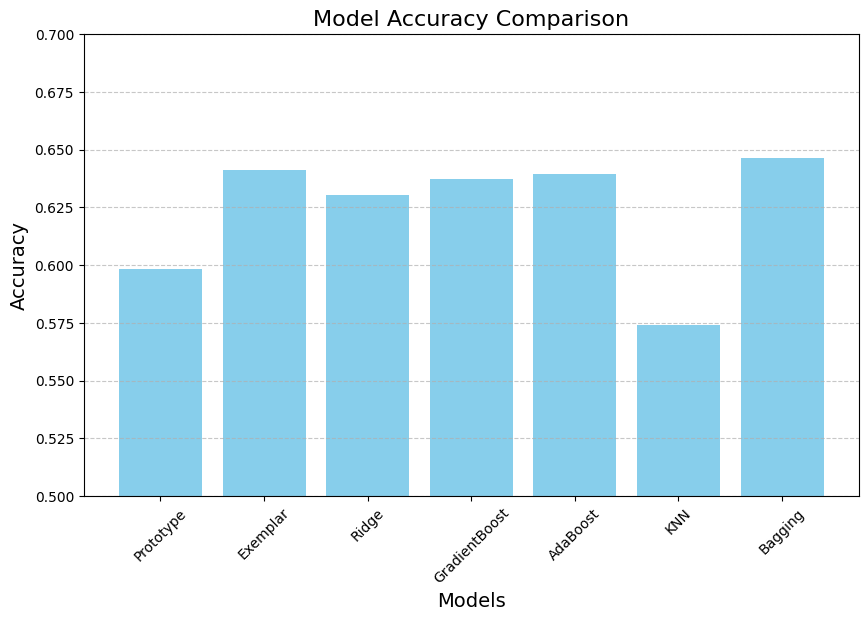

In [42]:
import matplotlib.pyplot as plt

# Extract model names and their corresponding accuracies
models = ['Prototype', 'Exemplar', 'Ridge', 'GradientBoost', 'AdaBoost', 'KNN', 'Bagging']
accuracies = [
    results_df['prototype_acc'].iloc[-1],
    results_df['exemplar_acc'].iloc[-1],
    results_df['ml_ridge_acc'].iloc[-1],
    results_df['ml_gradientBoost_acc'].iloc[-1],
    results_df['ml_adaBoost_acc'].iloc[-1],
    results_df['ml_knn_acc'].iloc[-1],
    results_df['ml_bagging_acc'].iloc[-1]
]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue')
plt.title('Model Accuracy Comparison', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Models', fontsize=14)
plt.ylim(0.5, 0.7)  # Adjust the y-axis range for better visualization
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

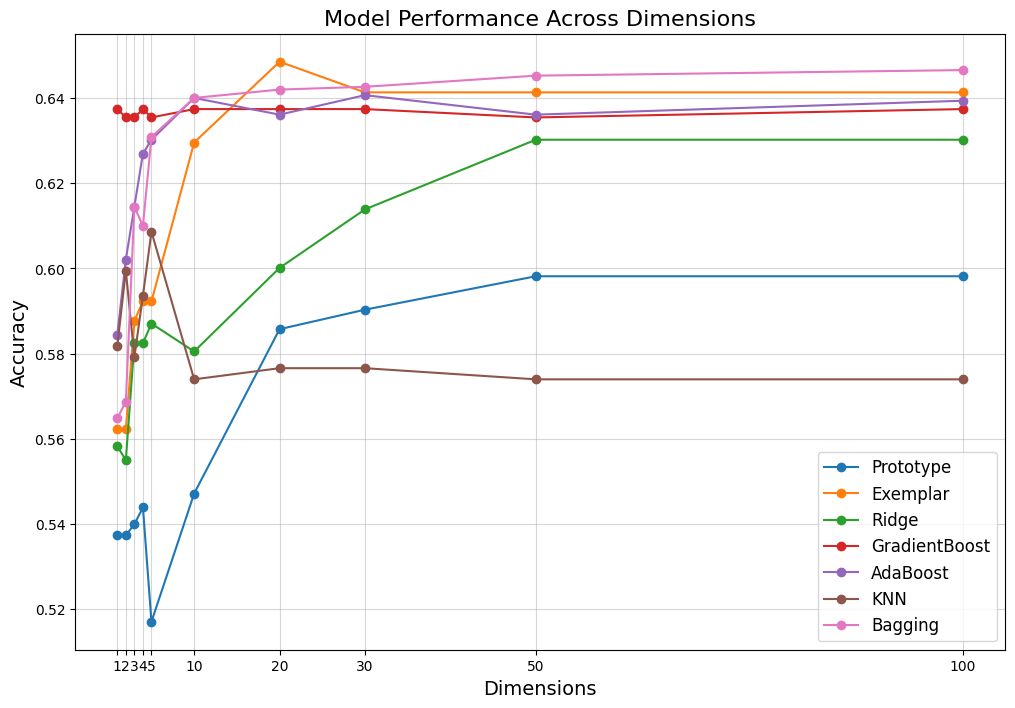

In [43]:
# Extract data for plotting
dims = results_df['dims']
prototype_acc = results_df['prototype_acc']
exemplar_acc = results_df['exemplar_acc']
ml_ridge_acc = results_df['ml_ridge_acc']
ml_gradientBoost_acc = results_df['ml_gradientBoost_acc']
ml_adaBoost_acc = results_df['ml_adaBoost_acc']
ml_knn_acc = results_df['ml_knn_acc']
ml_bagging_acc = results_df['ml_bagging_acc']

# Plot the line chart
plt.figure(figsize=(12, 8))
plt.plot(dims, prototype_acc, label='Prototype', marker='o')
plt.plot(dims, exemplar_acc, label='Exemplar', marker='o')
plt.plot(dims, ml_ridge_acc, label='Ridge', marker='o')
plt.plot(dims, ml_gradientBoost_acc, label='GradientBoost', marker='o')
plt.plot(dims, ml_adaBoost_acc, label='AdaBoost', marker='o')
plt.plot(dims, ml_knn_acc, label='KNN', marker='o')
plt.plot(dims, ml_bagging_acc, label='Bagging', marker='o')

# Add labels, title, and legend
plt.title('Model Performance Across Dimensions', fontsize=16)
plt.xlabel('Dimensions', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.xticks(dims)

# Show the plot
plt.show()

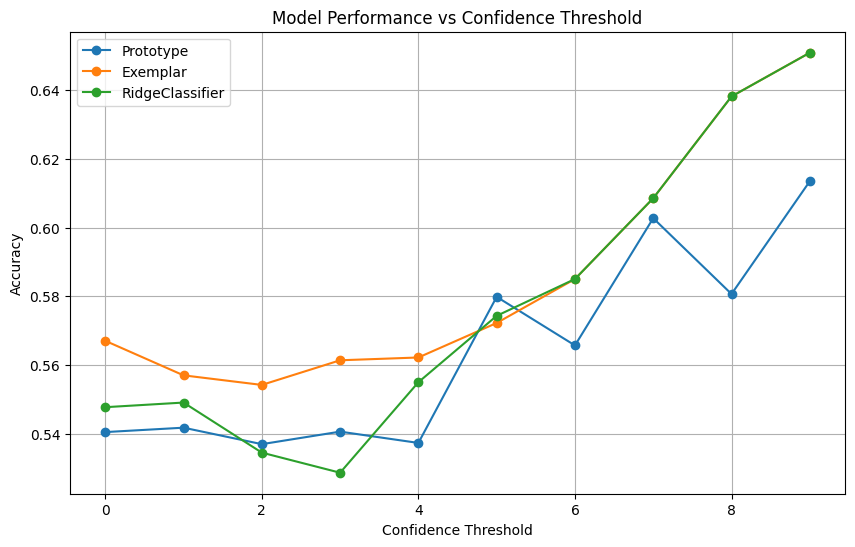

In [48]:
# Load PCA data and response data
df = pd.read_pickle('df_pca_2')
df["image"] = df["image"].str.extract(r'\((\d+)\)', expand=False)
df = df.dropna(subset=["image"])
df["image"] = df["image"].astype(int)

df_resp = pd.read_csv("./DATA AND R CODE/eachresponse.csv").dropna(how='any')

# Merge data on the "image" column
df_merged_all = pd.merge(df_resp, df, on="image", how="inner")
pca_columns = [i for i in range(0, 2)]

# Define a range of confidence thresholds to test
confidence_levels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
prototype_accs = []
exemplar_accs = []
ridge_accs = []

for conf in confidence_levels:
    # Filter merged DataFrame based on the current confidence threshold
    df_merged = df_merged_all[df_merged_all["confidence"] >= conf]

    # Skip if too few samples
    if len(df_merged) < 10:
        prototype_accs.append(None)
        exemplar_accs.append(None)
        ridge_accs.append(None)
        continue

    # Prepare data
    X = df_merged[pca_columns].values
    y = df_merged["choice"].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Prototype model
    ai_proto, real_proto = gen_prototypes(X_train, y_train)
    proto_preds = prototype_predict(ai_proto, real_proto, X_test)
    proto_acc = accuracy_score(y_test, proto_preds)

    # Exemplar model
    exemplars = gen_exemplars(X_train, y_train)
    exemp_preds = exemplar_predict(X_test, exemplars, c=5.0)
    exemp_acc = accuracy_score(y_test, exemp_preds)

    # ML model: RidgeClassifier
    clf = RidgeClassifier()
    clf.fit(X_train, y_train)
    ridge_preds = clf.predict(X_test)
    ridge_acc = accuracy_score(y_test, ridge_preds)
    
    # Save results
    prototype_accs.append(proto_acc)
    exemplar_accs.append(exemp_acc)
    ridge_accs.append(ridge_acc)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(confidence_levels, prototype_accs, marker='o', label='Prototype')
plt.plot(confidence_levels, exemplar_accs, marker='o', label='Exemplar')
plt.plot(confidence_levels, ridge_accs, marker='o', label='RidgeClassifier')
plt.xlabel('Confidence Threshold')
plt.ylabel('Accuracy')
plt.title('Model Performance vs Confidence Threshold')
plt.legend()
plt.grid(True)
plt.show()

Testing 1 dimensions...
Testing 2 dimensions...
Testing 3 dimensions...
Testing 4 dimensions...
Testing 5 dimensions...
Testing 10 dimensions...
Testing 20 dimensions...
Testing 30 dimensions...
Testing 50 dimensions...
Testing 100 dimensions...


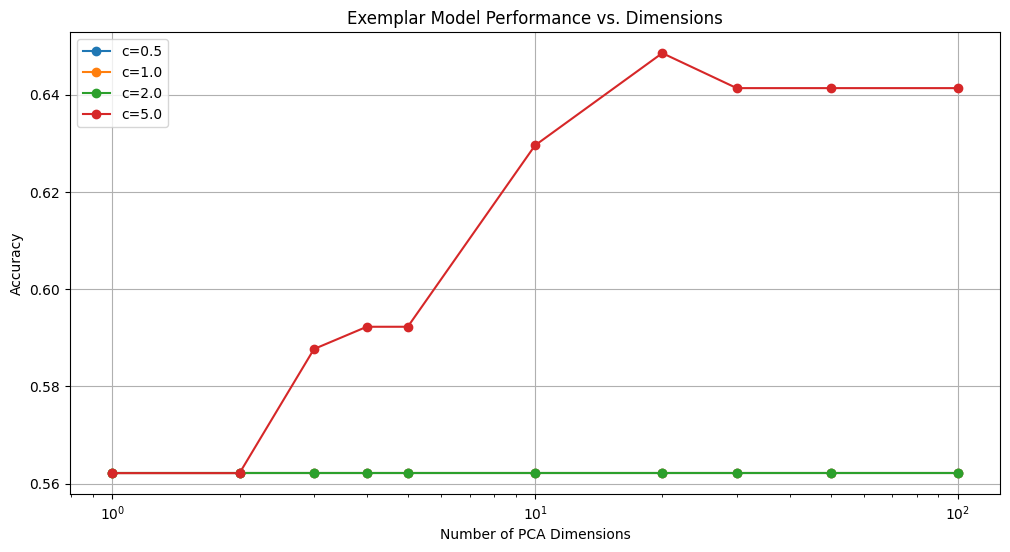


Detailed results:
    dimensions    c  accuracy
0            1  0.5  0.562173
1            1  1.0  0.562173
2            1  2.0  0.562173
3            1  5.0  0.562173
4            2  0.5  0.562173
5            2  1.0  0.562173
6            2  2.0  0.562173
7            2  5.0  0.562173
8            3  0.5  0.562173
9            3  1.0  0.562173
10           3  2.0  0.562173
11           3  5.0  0.587696
12           4  0.5  0.562173
13           4  1.0  0.562173
14           4  2.0  0.562173
15           4  5.0  0.592277
16           5  0.5  0.562173
17           5  1.0  0.562173
18           5  2.0  0.562173
19           5  5.0  0.592277
20          10  0.5  0.562173
21          10  1.0  0.562173
22          10  2.0  0.562173
23          10  5.0  0.629581
24          20  0.5  0.562173
25          20  1.0  0.562173
26          20  2.0  0.562173
27          20  5.0  0.648560
28          30  0.5  0.562173
29          30  1.0  0.562173
30          30  2.0  0.562173
31          30  5.0  

In [40]:
# Test exemplar model across PCA dimensions
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class ExemplarModel:
    def __init__(self, c=2.0):
        self.c = c
        self.exemplars = {}
        
    def fit(self, X_train, y_train):
        # Store exemplars by category
        self.exemplars = {
            'ai': X_train[y_train == 'ai'],
            'real': X_train[y_train == 'real']
        }
        
    def predict(self, X_test):
        predictions = []
        for stimulus in X_test:
            # Calculate distances using all available dimensions
            distances_ai = np.sqrt(np.sum((self.exemplars['ai'] - stimulus) ** 2, axis=1))
            distances_real = np.sqrt(np.sum((self.exemplars['real'] - stimulus) ** 2, axis=1))
            
            # Calculate similarity scores
            sim_ai = np.sum(np.exp(-self.c * distances_ai))
            sim_real = np.sum(np.exp(-self.c * distances_real))
            
            predictions.append('real' if sim_real > sim_ai else 'ai')
            
        return np.array(predictions)

# Test across different PCA dimensions
def test_exemplar_dimensions():
    pca_dfs = {
        1: 'df_pca_1', 2: 'df_pca_2', 3: 'df_pca_3', 
        4: 'df_pca_4', 5: 'df_pca_5', 10: 'df_pca_10',
        20: 'df_pca_20', 30: 'df_pca_30', 50: 'df_pca_50',
        100: 'df_pca_100'
    }
    
    # Load response data once
    df_resp = pd.read_csv("./DATA AND R CODE/eachresponse.csv").dropna(how='any')
    
    results = []
    c_values = [0.5, 1.0, 2.0, 5.0]  # Test different sensitivity values
    
    for dims, df_name in pca_dfs.items():
        print(f"Testing {dims} dimensions...")
        
        # Load and preprocess PCA data
        df_pca = pd.read_pickle(df_name)
        df_pca["image"] = df_pca["image"].str.extract(r'\((\d+)\)', expand=False)
        df_pca = df_pca.dropna(subset=["image"])
        df_pca["image"] = df_pca["image"].astype(int)
        
        # Merge datasets
        df_merged = pd.merge(df_resp, df_pca, on="image", how="inner")
        df_merged = df_merged[df_merged["confidence"] >= 4]  # Filter by confidence
        
        # Prepare data
        pca_columns = list(range(dims))
        X = df_merged[pca_columns].values
        y = df_merged["choice"].values
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Test each c value
        for c in c_values:
            model = ExemplarModel(c=c)
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            
            results.append({
                'dimensions': dims,
                'c': c,
                'accuracy': acc
            })
    
    return pd.DataFrame(results)

# Run the test and plot results
results_df = test_exemplar_dimensions()

# Plot results
plt.figure(figsize=(12, 6))
for c in results_df['c'].unique():
    subset = results_df[results_df['c'] == c]
    plt.plot(subset['dimensions'], subset['accuracy'], 
             marker='o', label=f'c={c}')

plt.xscale('log')
plt.xlabel('Number of PCA Dimensions')
plt.ylabel('Accuracy')
plt.title('Exemplar Model Performance vs. Dimensions')
plt.legend()
plt.grid(True)
plt.show()

print("\nDetailed results:")
print(results_df.sort_values(['dimensions', 'c']))